# Task 1. Supervised Learning with Neural Networks

Task 1 will involve implementing a simple Neural Network that classifies 2d gray scale images and training it using backpropagation and an optimiser.

### Set-up

Load required packages (you can only use the imported packages for this task).

In [1]:
import matplotlib.pyplot as plt # use this to plot training charts at your discretion
import numpy as np 
import glob # used esclusively to load files from folders
from PIL import Image # used to manipulate images and prepare data (you should not need it)
import math

### Task 1.1 Implement a simple ReLu activation neuron, a premade implementation of a Linear Layer that goes with it is provided to you. For each of these two components describe the role of each method and how the two components work together.

Answer:

#### You can follow the template below, but feel free to start from scratch with your own design.


#### ReLu Activation

#### Relu activation is applied after each linear operation. Relu activation is better than sigmoid since it avoids vanishing gradient problem. This is because Relu activation keep only positive values and the gradient of the activation equals 1 for those, in contrast the gradient of sigmoid is always less than 1.

In [2]:

class ReLu:
    # Implement a variable that will store the input during the forward pass
    def __init__(self):
        self.input = None
    # Implement the forward pass of the ReLU
    def forward(self, x):
        self.input = x
        
        return self.input*(self.input>0)

    # Implement the gradient for the backward pass
    def backward(self, gradient_output):
        
        return gradient_output*(self.input>0)



#### The output of a relu activation are unbounded though and this can result to exploding gradients because of the large values, a simple solution for this problem is to implement a batch normalisation after each Relu activation which will help have stable outputs across the layers and avoid exploding gradients

In [3]:
class BatchNorm:
    # Implement a variable that will store the input during the forward pass
    def __init__(self):
        self.input = None
        self.std=None
        self.mean=None

    def forward(self, x):
        self.input = x
        self.std=np.std(self.input,axis=0)
        self.mean=np.mean(self.input,axis=0)
        return (self.input-self.mean)/(self.std+1)#add 1 to avoid division with zero in case std=0

    # Implement the gradient for the backward pass
    def backward(self, gradient_output):
        
        return gradient_output/(self.std+1)#gradients are shrinked, hence exploding gradients can be avoided


#### Linear Layer

In [4]:
# Linear Layer. You can use it as is.
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim) # 'He et al' init strategy
        self.biases = np.zeros((1, output_dim))
        self.input = None
        self.grad_weights = None
        self.grad_biases = None

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

### Task 1.2 Implement a simple feed forward neural network, its loss function and a method for backpropagation

In [5]:
class NeuralNetwork:
    def __init__(self, layers = []):
        #initialising variables
        self.layers = layers
        self.l=1
        self.gradients=None
        self.out=None
        self.parameters=None
    # a simple function that can be used to add 
    def add_layer(self, layer):
        self.layers.append(layer)

    # Implement a function that applies the input x iteratively to each layer and return the final output
    def forward(self, x):
        self.out=x
        for layer in self.layers:
          
            self.out=layer.forward(self.out)
        return self.out

    # Implement a function that iteratively backpropagate the gradients. Remember to start from the last layer.
    def backward(self, gradient_output):
        self.l=gradient_output
        self.parameters=[]
        self.gradients=[]
        
        for layer in self.layers[::-1]:
            self.l = layer.backward(self.l)#backpropagation of gradient
            if isinstance(layer, Linear):
                #store weights and gradients for linear layers
                self.gradients.append([layer.grad_weights,layer.grad_biases])
                self.parameters.append([layer.weights,layer.biases])
        return self.l
    
    # implement a function that returns all the parameters for each layer (both weights and biases) and the gradients
    def parameters_and_gradients(self):
                        
        return self.gradients,self.parameters

#### Implement the categorical cross entropy loss function:


$-\sum_{c=1}^My_{o,c}\log(p_{o,c})$
* M - number of classes

* log - the natural log

* y - binary indicator (0 or 1) if class label c is the correct classification for observation o

* p - predicted probability observation o is of class c

In [6]:
# Implement the categorical cross entropy loss function
def cce_loss(y_true, y_pred):
    loss = -np.sum(y_true*np.log(y_pred))
    return loss

In order to turn the output of the neural network's last layer into probabilities a softmax function should be used.
An implementation of the function and its derivative is provided for your convenience.

In [7]:
# Softmax 
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

# the derivative is that simple due to a combination of choices, the one hot encoding and the use of cross entropy as loss function.
def derivative_cross_entropy_softmax(preds, labels):
    return preds - labels

### Task1.3 Implement the optimiser based on gradient descent described by the formula:
$ \theta = \theta – \eta \cdot \nabla_\theta J(\theta)$

* $\theta$ is a parameter that will be updated
* $\eta$ is the learning rate 
* $\nabla_\theta J(\theta)$ is the gradient of the loss function $J$ with respect to $\theta$

In [8]:
# Implement a function that iterates over the parameters and update them based on the learning rate and the gradients
def sgd(parameters,gradients, learning_rate):
    for i in range(len(gradients)):
        for j in range(len(parameters[0])):
            parameters[i][j]= parameters[i][j]-learning_rate*gradients[i][j]
    return parameters

### Task1.4 Implement the training loop


In [9]:
def train(network, X_train, Y_train, batch_size, epochs, learning_rate):
    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size
            
    losses=[]            
    for epoch in range(epochs):
        # shuffle data on each epoch
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        Y_train_shuffled = Y_train[indices]
        loss=0
        # a guarded batching loop is provided for your convenience
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            end = min(end,n_samples)

            X_batch = X_train_shuffled[start:end]
            Y_batch = Y_train_shuffled[start:end]
        
         # Implement the necessary missing operations:
            
       
            # - Predict classes for the batch of observations (remember to use softmax on the NN output)
            output=network.forward(X_batch)
            predict=softmax(output)
            # - Compute the loss between predictions and true lables
            loss+=cce_loss(Y_batch,predict)
            if np.isnan(loss):
                break
            # - Compute the gradient of the softmax operation
            gradient=derivative_cross_entropy_softmax(predict,Y_batch)
            # - Backpropagate the gradients thoughout the network
            network.backward(gradient)
            #getting gradients and parameters from neural network
            gradients,parameters=network.parameters_and_gradients()
            # - Use the gradient descent function to update the parameters 
            parameters=sgd(parameters,gradients, 0.2)
            
            #iteratively updating the new parameters after the gradient descent
            i=0
            for obj in network.layers[::-1]:
                if isinstance(obj, Linear):
                    obj.weights=parameters[i][0]
                    obj.biases=parameters[i][1]
                    i+=1
        #average loss per batch
        loss=loss/n_batches
        losses.append(loss)        
        
        print(f"Epoch {epoch+1}, Loss: {loss}")
    return losses

### Task1.5 Instantiate a Neural Network and train it on the provided dataset, then present and evaluate the results obtained by using the Neural Network on the provided test set

In [10]:
#Unzip the folder you have been provided with in the same folder as this jupyter notebook. This code will prepare training and test sets.
filelist = glob.glob('dataset1/train/*.png')
train_images_np = np.array([np.array(Image.open(fname)) for fname in filelist])
classes_labels_train = np.array([int(fname[-5:-4]) for fname in filelist]) #labels are encoded in the last digit of the name
# encoding the training set labels into one hot encoding
train_labels = np.zeros((classes_labels_train.size, classes_labels_train.max()+1), dtype=int)
train_labels[np.arange(classes_labels_train.size),classes_labels_train] = 1 


filelist = glob.glob('dataset1/test/*.png')
images_np_test = np.array([np.array(Image.open(fname)) for fname in filelist])
classes_labels_test = np.array([int(fname[-5:-4]) for fname in filelist]) #labels are encoded in the last digit of the name
# encoding the test set labels into one hot encoding
test_labels = np.zeros((classes_labels_test.size, classes_labels_test.max()+1), dtype=int)
test_labels[np.arange(classes_labels_test.size),classes_labels_test] = 1 


In [11]:
train_images_np.shape

(2400, 32, 32)

In [12]:
n_samples1 = train_images_np.shape[0]
train_images=np.zeros([n_samples1,np.product(train_images_np[0].shape)])
train_images.shape

(2400, 1024)

In [13]:
n_samples2 = images_np_test.shape[0]
test_images=np.zeros([n_samples2,np.product(images_np_test[0].shape)])
test_images.shape

(480, 1024)

In [14]:
train_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
n_samples1

2400

In [16]:
n_samples2

480

In [17]:
for i in range(n_samples1):
    train_images[i]=np.reshape(train_images_np[i], (1,np.product(train_images_np[i].shape)))
    

In [18]:
for i in range(n_samples2):
    test_images[i]=np.reshape(images_np_test[i], (1,np.product(images_np_test[i].shape)))

In [19]:

train_images


array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [20]:
test_images

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

#### Instantiate the network and set the training parameters

In [21]:
# Initialising different Networks below for testing
#add min max preprocessing, important for features to have same scale

In [22]:
n6=NeuralNetwork(layers=[BatchNorm(),Linear(1024,800),ReLu()])
n6.add_layer(BatchNorm())
n6.add_layer(Linear(800,500))
n6.add_layer(ReLu())
n6.add_layer(BatchNorm())
n6.add_layer(Linear(500,250))
n6.add_layer(ReLu())
n6.add_layer(BatchNorm())
n6.add_layer(Linear(250,100))
n6.add_layer(ReLu())
n6.add_layer(BatchNorm())
n6.add_layer(Linear(100,50))
n6.add_layer(ReLu())
n6.add_layer(BatchNorm())
n6.add_layer(Linear(50,10))
n6.add_layer(BatchNorm())


In [23]:
n5=NeuralNetwork(layers=[BatchNorm(),Linear(1024,600),ReLu()])
n5.add_layer(BatchNorm())
n5.add_layer(Linear(600,250))
n5.add_layer(ReLu())
n5.add_layer(BatchNorm())
n5.add_layer(Linear(250,100))
n5.add_layer(ReLu())
n5.add_layer(BatchNorm())
n5.add_layer(Linear(100,40))
n5.add_layer(ReLu())
n5.add_layer(BatchNorm())
n5.add_layer(Linear(40,10))
n5.add_layer(BatchNorm())

In [24]:
n4=NeuralNetwork(layers=[BatchNorm(),Linear(1024,400),ReLu()])
n4.add_layer(BatchNorm())
n4.add_layer(Linear(400,120))
n4.add_layer(ReLu())
n4.add_layer(BatchNorm())
n4.add_layer(Linear(120,40))
n4.add_layer(ReLu())
n4.add_layer(BatchNorm())
n4.add_layer(Linear(40,10))
n4.add_layer(BatchNorm())

In [25]:
n3=NeuralNetwork(layers=[BatchNorm(),Linear(1024,200),ReLu()])
n3.add_layer(BatchNorm())
n3.add_layer(Linear(200,50))
n3.add_layer(ReLu())
n3.add_layer(BatchNorm())
n3.add_layer(Linear(50,10))
n3.add_layer(BatchNorm())

In [26]:
n2=NeuralNetwork(layers=[BatchNorm(),Linear(1024,200),ReLu()])
n2.add_layer(BatchNorm())
n2.add_layer(Linear(200,10))
n2.add_layer(BatchNorm())


In [27]:
n1=NeuralNetwork(layers=[BatchNorm(),Linear(1024,10)])
n1.add_layer(BatchNorm())


In [28]:
# Training Parameters - set the appropriate parameters
batch_size = 10
epochs = 10
learning_rate = 0.2

#### Train the networks

In [29]:
networks=[n1,n2,n3,n4,n5,n6]

In [30]:
losses=[]
for i in range(len(networks)):
    losses.append(train(networks[i], train_images, train_labels, batch_size, epochs, learning_rate))

Epoch 1, Loss: 13.181232419933785
Epoch 2, Loss: 12.216339718140194
Epoch 3, Loss: 12.090001920873737
Epoch 4, Loss: 11.933496882636286
Epoch 5, Loss: 11.850025484276905
Epoch 6, Loss: 11.809081159151571
Epoch 7, Loss: 11.994822888635642
Epoch 8, Loss: 11.8492155827518
Epoch 9, Loss: 11.700201727884311
Epoch 10, Loss: 11.7784108875526
Epoch 1, Loss: 12.485183204352555
Epoch 2, Loss: 11.471656134179463
Epoch 3, Loss: 11.162687292106092
Epoch 4, Loss: 11.41730056011525
Epoch 5, Loss: 11.285723271661292
Epoch 6, Loss: 11.173438942379564
Epoch 7, Loss: 11.130911234822007
Epoch 8, Loss: 11.151754282606507
Epoch 9, Loss: 11.328914237019879
Epoch 10, Loss: 11.094459406606347
Epoch 1, Loss: 13.667226600385158
Epoch 2, Loss: 12.120674588385196
Epoch 3, Loss: 11.924540995927162
Epoch 4, Loss: 11.858781216439677
Epoch 5, Loss: 11.93659094456877
Epoch 6, Loss: 11.914072608604757
Epoch 7, Loss: 11.901918196682017
Epoch 8, Loss: 11.741798529573503
Epoch 9, Loss: 12.094917807320321
Epoch 10, Loss: 11

#### Test the network and present the results. This can be aided by plots. Critically evaluate the results. You are encourage to try different parameters and setting, and searching for the smallest most efficient network that can learn the task.

In [31]:
accuracy_train=[]
accuracy_test=[]
for i in range(len(networks)):
    output=softmax(networks[i].forward(train_images))
    accuracy_train.append(np.mean(output.argmax(axis=1)==train_labels.argmax(axis=1)))
    output=softmax(networks[i].forward(test_images))
    accuracy_test.append(np.mean(output.argmax(axis=1)==test_labels.argmax(axis=1)))

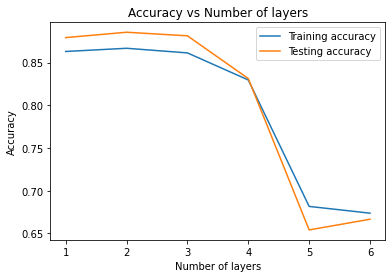

In [32]:
plt.figure()
layers=[1,2,3,4,5,6]
plt.plot(layers,accuracy_train)
plt.plot(layers,accuracy_test)
plt.xlabel("Number of layers")
plt.ylabel("Accuracy")
plt.legend(['Training accuracy', 'Testing accuracy'])
plt.title('Accuracy vs Number of layers')
plt.show()

In [33]:
accuracy_test

[0.8791666666666667,
 0.8854166666666666,
 0.88125,
 0.83125,
 0.6541666666666667,
 0.6666666666666666]

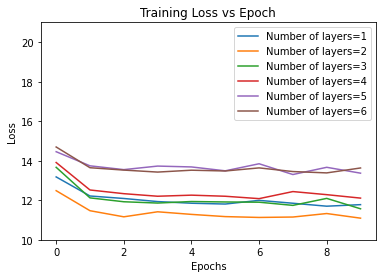

In [34]:
plt.figure()
for i in range(len(losses)):
    plt.plot(losses[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(10, 21)
plt.title('Training Loss vs Epoch')
plt.legend(['Number of layers=1', 'Number of layers=2','Number of layers=3','Number of layers=4','Number of layers=5','Number of layers=6',])
plt.show()

#### 1 and 2 layer neural networks have about the same performance, 2 layer neural network has the lowest overall loss, 2 layer neural network has the slightly better testing accuracy in most of the runs, the overall trend is that the deeper the network the more likely is to suffer from vanishing gradients which causes a decrease in accuracy of the model. The fact that training accuracy and test accuracy follow a similar pattern also suggests that there is no overfitting, if there was overfitting a much higher training accuracy would be observed and the training loss would be much less. 


# Task 2 Self-Supervised Learning with Convolutional Autoencoders
Task 2 will involve constructing a Convolutional Autoencoder and training it on a collection of unlabelled RGB images in order to create a 2D latent space. After visualising how the inputs are encoded into 2d vectors by the network the pre-trained encoder will be extended with a dense classification layer that will be trainined on a smaller set of labelled images.

In this task you are allowed to use torch to build your encoder-decoder network.




### Set-up

Load required packages (you can only use the imported packages for this task).

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob # used esclusively to load files from folders
from PIL import Image # used to manipulate images and prepare data (you should not need it)

In [36]:
filelist = glob.glob('dataset2/unlabelled/*.png') # Use these files to pre-train the autoencoder
filelist2 = glob.glob('dataset2/train/*.png') # Use these files to train the classifier
filelist3 = glob.glob('dataset2/test/*.png') # Use these files to test the classifier
unlabelled_images = np.array([np.array(Image.open(fname)) for fname in filelist])

train_images = np.array([np.array(Image.open(fname)) for fname in filelist2])
train_labels = np.array([int(fname[-5:-4]) for fname in filelist2])

test_images = np.array([np.array(Image.open(fname)) for fname in filelist3])
test_labels = np.array([int(fname[-5:-4]) for fname in filelist3])

In [37]:
class CustomDataset(Dataset):
    def __init__(self, numpy_array):
        self.data = torch.tensor(numpy_array, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # Convert to torch.Tensor and normalize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

### Task 2.1 set up an Autoencoder using torch convolutional layers. Make the encoder and decoder at least a few layers deep each. 
#### Further:
* Describe the 2D convolution operation, provide the formula used by the library and the meaning of the parameters.
* Describe each layer you have decided to use beyond that, provide the underlying formulas and the meaning of the parameters.
* If one type of layer is used multiple times one explaination is sufficient.

Answer:

In [38]:
# Convolutional Auto Encoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(3),#normalising data to avoid vanishing gradients, same way as done in Task1 but in 2d
            
            #symmetric kernel are used hence dimensions remain symmetric
            #kernel size=3 
            #stride is the step movement of the kernel
            #padding is the increase of size of the image that is added both at the beginning and end
            #for example padding=1 adds zeros to make input dimension to (3,66,66)
            #output_dimension=floor((input_dimension+2*padding-kernel_size)/stride)+1
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # Input: (3, 64, 64), Output: (16, 32, 32)
          
            ## Implement here your architecture using torch layers
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            
            #At this point the output of 128 kernels of 4*4 is converted to a vector to feedforward in linear layers
            nn.Linear(128*4*4,100),#linear operations same as used in Task1
            nn.Linear(100,2),
            
            
        )

        # Remember that the last layer of the encoder and the first layer of the decoder should be the same 
        
        # Decoder
        self.decoder = nn.Sequential(

            #linear linears to increase to 128*4*4 again
            nn.Linear(2,100),
            nn.Linear(100,128*4*4),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),#Inverse operation of convolution
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 2, stride=2, padding=0),
            #nn.BatchNorm2d(3) batch norm at the end also loses information and it was avoided
        )

    def forward(self, x):
            
        a=self.encoder
        for i in a:
            if isinstance(i, nn.BatchNorm2d): 
                x=i(x)
            if isinstance(i, nn.Conv2d): 
                x=i(x)
                x=torch.relu(x)#relu activation
                
        #converting to vector to feedforward to linear layers    
        x = x.view(x.size(0), -1)
        for i in a:
            if isinstance(i, nn.Linear): 
                x=i(x)
                #x=torch.relu(x) relu activation was found that it loses information at this point so it was avoided
                
        encoded = x
        
        b=self.decoder
        for j in b:
            if isinstance(j, nn.Linear): 
                x=j(x)
                #x=torch.relu(x) similarly here relu was found that it loses important information
        #converting to 128 outputs of 4*4 to reproduce the pictures from encoded
        x=x.view(-1,128,4,4)
        for k in b:
            if isinstance(k, nn.BatchNorm2d): 
                x=k(x)
            if isinstance(k, nn.ConvTranspose2d): 
                x=k(x)
                x=torch.relu(x)
        decoded = x
        return encoded, decoded


In [39]:
# Training loop
def train_autoencoder(model, dataloader, loss_function, optimiser, epochs):
    model.train()
    for epoch in range(epochs):
        for imgs in dataloader:
          
            optimiser.zero_grad()
            _ , outputs = model(imgs) # here the encoded values are not used, but you will need it later
            loss = loss_function(outputs, imgs)
            loss.backward()
            optimiser.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [40]:
# Parameters (Adjust as needed)
batch_size = 10
epochs = 10
learning_rate = 0.001

# Instantiation of the model
autoencoder = Autoencoder()

# loss function and optimiser
loss_function = nn.MSELoss()
optimisation_alg = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Dataset Preparation
imageSize = 64
transform = transforms.Compose([
    transforms.Resize((imageSize, imageSize)),
    transforms.ToTensor(),
])
custom_dataset = CustomDataset(unlabelled_images)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# training
train_autoencoder(autoencoder, dataloader,loss_function,optimisation_alg, epochs)



Epoch 1, Loss: 0.05442548543214798
Epoch 2, Loss: 0.042469557374715805
Epoch 3, Loss: 0.04001394286751747
Epoch 4, Loss: 0.03800230473279953
Epoch 5, Loss: 0.03736623749136925
Epoch 6, Loss: 0.03668307885527611
Epoch 7, Loss: 0.03640849143266678
Epoch 8, Loss: 0.03824671730399132
Epoch 9, Loss: 0.0377563014626503
Epoch 10, Loss: 0.03823941946029663


### Task 2.2 Use the pretrained encoder to extract the encoded 2D vectors and plot them using matplotlib

In [41]:
# Implement the extraction of the encoded input.
def latent_space(autoencoder, dataloader):
    # make sure to use the autoencoder in evaluation mode. Do not compute the gradients.
    model=autoencoder 
    model.eval()
    latent_spaces=torch.zeros(unlabelled_images.shape[0],2)

    i=0
    for imgs in dataloader:
        encoded , decoded = model(imgs)
        latent_spaces[i:encoded.shape[0]+i,0:2]=encoded
        i+=encoded.shape[0]
    # use the autoencoder to produce the latent spaces. Here is where you have to get the encoded values instead of the outputs
    latent_spaces=latent_spaces.detach().numpy()
    return latent_spaces

In [42]:
coordinates = latent_space(autoencoder, dataloader)

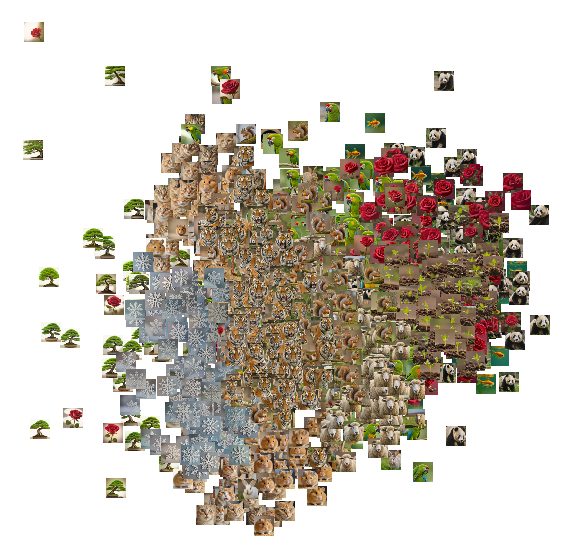

In [43]:
# Plotting function. If the training is succesful similar images should be clustered together.
def plot_latent_space(latent_space):

    def getImage(path, zoom=1):
        return OffsetImage(plt.imread(path), zoom=0.3)

    x = latent_space[:,0]
    y = latent_space[:,1]

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.scatter(x, y)

    for x0, y0, path in zip(x, y, filelist): #if you shuffled the data then you must update the filelist array accordingly
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    plt.axis('off')

coordinates = latent_space(autoencoder, dataloader)
plot_latent_space(coordinates)